In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np 
import cvxpy as cvx 
from gurobipy import * 
from scipy.optimize import minimize
import pickle
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import collections as matcoll
from sklearn import svm
from cate_sensitivity_helpers import * 
from scipy.stats import norm
from scipy.stats import multivariate_normal

<IPython.core.display.Javascript object>

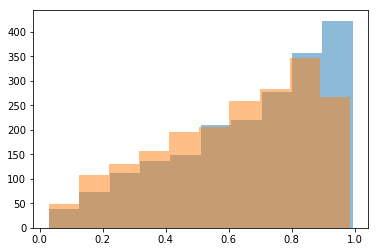

In [2]:

d = 3 # dimension of x 
n = 2000; 
#parameters
rho = np.asarray([1/np.sqrt(2), -1/np.sqrt(2), 0, 0, 1/np.sqrt(3)]) # normalize to unit 0.5
rho = rho / (np.dot(rho,rho)*2)
# coefficient of treatment effect

## reversion back to old version 
beta_cons = -1.5
beta_x = np.asarray([0.5, 0.5, 0.5]) #0,0,]) #
beta_T = np.asarray([0.75, -0.5, 0.5, 0.5])
beta_x_u = np.asarray([1, 0, 0, ])
mu_x = np.asarray([0,-.5,-0.5]);


# generate propensity model 
def REAL_PROP_LOG(x, u, Gamma): 
    prop = logistic_pol_asgn(beta_T, x)
    # set u = I[ Y(T)\mid x > Y(-T) \mid x ]
    a_bnd, b_bnd = get_bnds(prop, Gamma)
    q_lo = 1/b_bnd ; q_hi = 1/a_bnd 
    #### ''adversarial generation'' 
#     opt_T = return_CATE_optimal_assignment(x, u)
#     q_real = np.asarray([ q_lo[i] if opt_T[i] == 1 else q_hi[i] for i in range(len(u)) ])
    q_real = np.asarray([ q_hi[i] if u[i] > 0.5 else q_lo[i] for i in range(len(u)) ])
    return q_real 

def generate_log_data(mu_x, n, beta_cons, beta_x, beta_x_u, Gamma): 
    # generate n datapoints from the same multivariate normal distribution
    d = len(mu_x)
    xi = np.random.rand(n)
    u = (xi > 0.5) # needs to be Rademacher
    x = np.zeros([n, d])
    x = np.random.uniform(low=X_A, high=X_B, size=(n,d))
    x_ = np.hstack([x, np.ones([n,1])])
    # generate propensities
    true_Q = REAL_PROP_LOG(x_, u, Gamma)
    T = np.array(np.random.uniform(size=n)  < true_Q).astype(int).flatten()
    T = T.reshape([n,1]); T_sgned = np.asarray([ 1 if T[i] == 1 else -1 for i in range(n)]).flatten()

    nominal_propensities_pos = logistic_pol_asgn(beta_T, x_)
    q0 = np.asarray( [nominal_propensities_pos[i] if T[i] == 1 else 1-nominal_propensities_pos[i]  for i in range(n)] )
    true_Q_obs = np.asarray( [true_Q[i] if T[i] == 1 else 1-true_Q[i]  for i in range(n)] )
    Y = np.zeros(n)
    nu = 2
    for i in range(n): 
        alpha = 1 
        Y[i] =  ( T_sgned[i]*x[i,CATE_ind] + alpha*T_sgned[i]  \
        - nu*(2*u[i] + u[i]*np.dot(beta_x_u.T, x[i,:]) + np.dot(beta_x.T, x[i,:]) - 1)   \
        - 2*np.sin(T_sgned[i]*2*x[i,CATE_ind]))         # constant 

    T = T.flatten()
    Y += np.random.randn(n) ; 
    return [x_, u, T, Y, true_Q_obs, q0]

def generate_unconfounded_data(mu_x, n, beta_cons, beta_x, beta_x_u): 
    # generate n datapoints from the same multivariate normal distribution
    d = len(mu_x)
    xi = np.random.rand(n); u = (xi > 0.5); x = np.zeros([n, d]) # needs to be Rademacher
    for i in range(n): 
        x[i,:] = np.random.multivariate_normal(mean = mu_x, cov= np.eye(d))#*(2*u[i]-1), cov= np.eye(d))
    x_ = np.hstack([x, np.ones([n,1])])
    # generate propensities
    true_Q = np.ones(n)*0.5; T = np.array(np.random.uniform(size=n)  < true_Q).astype(int).flatten()
    T = T.reshape([n,1]); T_sgned = np.asarray([ 1 if T[i] == 1 else -1 for i in range(n)]).flatten()
    true_Q_obs = np.asarray( [true_Q[i] if T[i] == 1 else 1-true_Q[i]  for i in range(n)] )
    Y = np.zeros(n)
    for i in range(n): 
        alpha = 1 ; nu = 2
        Y[i] =  ( T_sgned[i]*x[i,CATE_ind] + alpha*T_sgned[i]  \
        - nu*(2*u[i] + u[i]*np.dot(beta_x_u.T, x[i,:]) + np.dot(beta_x.T, x[i,:]) - 1)   \
        - 2*np.sin(T_sgned[i]*2*x[i,CATE_ind]))         # constant 
#         Y[i] =  T[i]*beta_cons + \
#         0.5*(1-x_[i,CATE_ind])**2*T[i] + np.dot(beta_x.T, x_[i,:]) \
#         + w*(2*u[i]-1)
        # + np.dot(beta_x_T.T, x_[i,:]*T[i]) \
    # add random noise
    T = T.flatten()
    Y += np.random.randn(n) 
    return [x_, u, T, Y, true_Q_obs, q0]

def return_CATE_optimal_assignment(x, u): 
    n = x.shape[0]
    risk_T_1 = real_risk_(np.ones(n), x,u) 
    risk_T_0 = real_risk_(np.zeros(n), x,u) 
    opt_T = [ 1 if risk_T_1[k] < risk_T_0[k] else 0 for k in range(n)] 
    return opt_T 
X_A = -2.25; X_B = 2.25; Rx = 2.25
# augment x dim by one 
CATE_ind = 0
Gamma = 1
[x, u, T, Y, true_Q, q0] = generate_log_data(mu_x, n, beta_cons, beta_x, beta_x_u, Gamma)
#compute real risk 
renormalize_theta = lambda tht: tht * np.abs(min(np.divide(0.5*np.ones(len(tht)), tht)))
C = 200

Q = true_Q
plt.hist(true_Q,alpha=0.5)
plt.hist(q0,alpha=0.5)
x_u = np.hstack([x,u.reshape([len(u),1])])

In [3]:
from statsmodels.nonparametric.kernel_regression import KernelReg
model = KernelReg(np.asarray(Y).flatten()[T==1], x[T==1,CATE_ind], var_type='c', reg_type='lc', bw='cv_ls')
model_0 = KernelReg(np.asarray(Y).flatten()[T==0], x[T==0,CATE_ind], var_type='c', reg_type='lc', bw='cv_ls')
print model.bw, model_0.bw
s1 = model.bw*np.sqrt(2)
s0 = model_0.bw*np.sqrt(2)

data = {'x': x[:,CATE_ind], 'y': np.asarray(Y).flatten(), 'tsgn': get_sgn_0_1(T), 'q0': q0, 'true_Q':np.asarray(true_Q).flatten(), 'sign':1}
data['sense'] = 1; data['X_lo'] = X_A; data['X_hi'] = X_B
data['weight_type'] = 'scale_invariant'
xs=np.arange(-Rx,Rx,.02)


[0.25161511] [0.18120906]


Computing bounds for T=1,
Computing bounds for T=1,
Computing bounds for T=1,


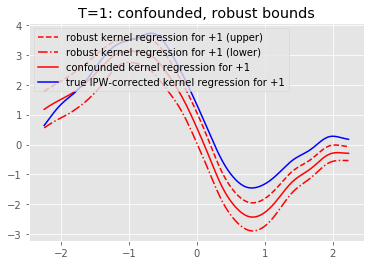

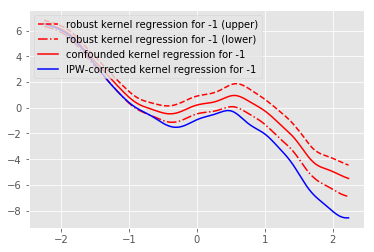

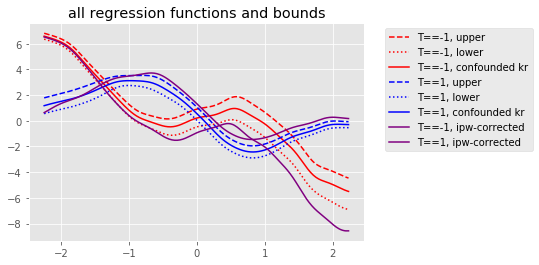

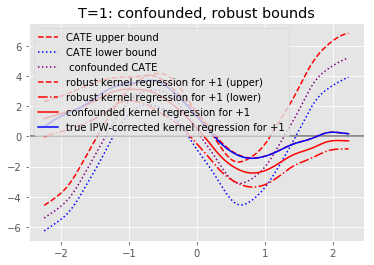

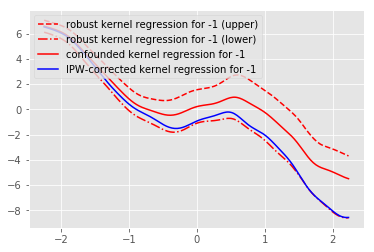

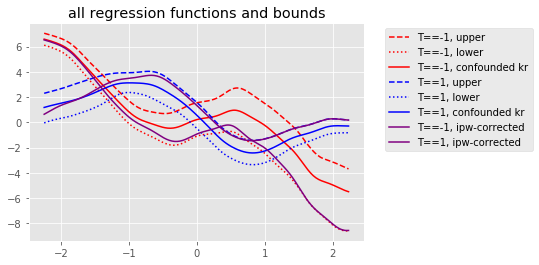

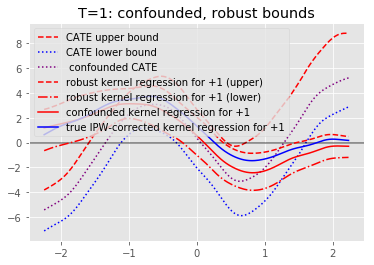

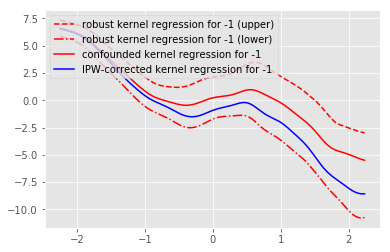

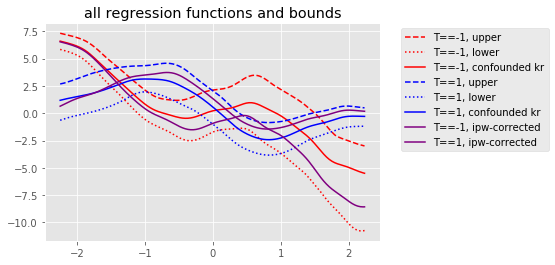

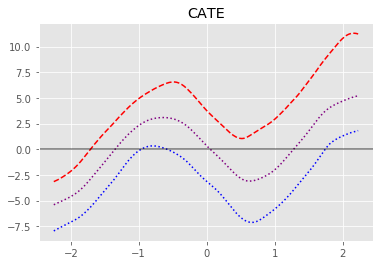

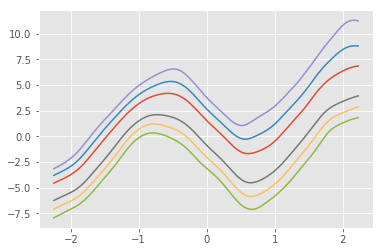

In [4]:
data['X_lo'] = X_A
data['X_hi'] = X_B
GAMS = [0.5, 1, 1.5]#np.log([1.1, 1.5, 2, 3])
diff_gams_res = plot_cate_diff_gams(xs, data, GAMS, s0)
# diff_gams_res = plot_cate_diff_gams(xs, data, GAMS, s0, s1)

## Figure 2

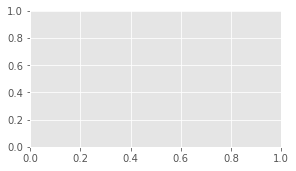

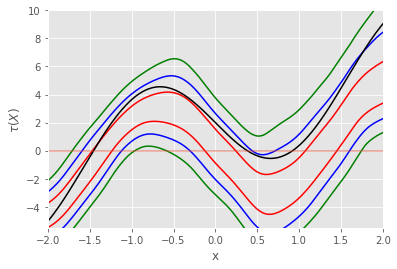

In [7]:
colors = ['r', 'b', 'g','gray', 'brown', 'pink']
fig,ax = plt.subplots(figsize=(4.5,2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plot_mult_gams(xs, diff_gams_res, (GAMS), colors)
plt.xlabel('x')
plt.ylabel(r'$\tau(X)$')
plt.xlim(-2,2)
truecate = -(-2*xs + -2 + 2*np.sin(2*xs) - 2*np.sin(-2*xs))
plt.plot(xs, truecate,color='black', label=r'$\tau(X)$')
plt.axhline(y=0,alpha=0.5)
plt.ylim(-5.5,10)
plt.xlabel('x')

plt.savefig('partial_cate-1D--specified-allxs.pdf')

Computing bounds for T=1,
Computing bounds for T=1,
Computing bounds for T=1,


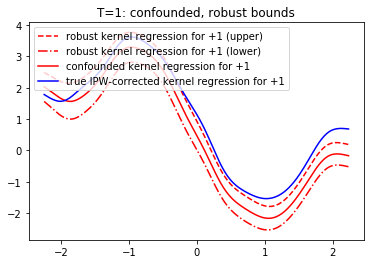

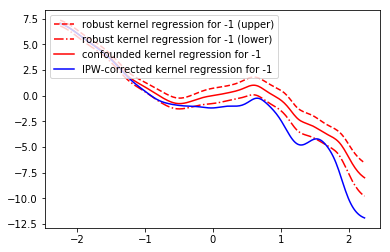

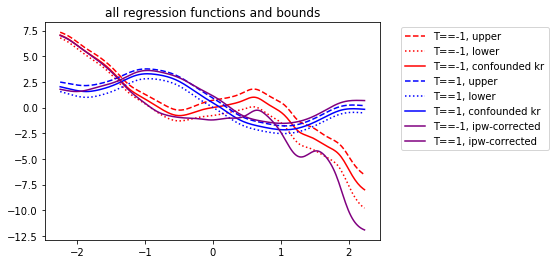

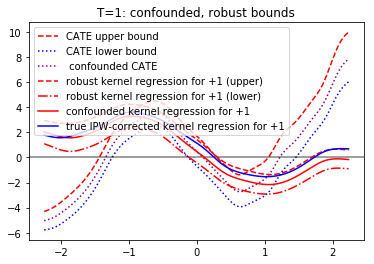

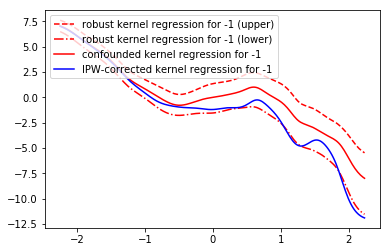

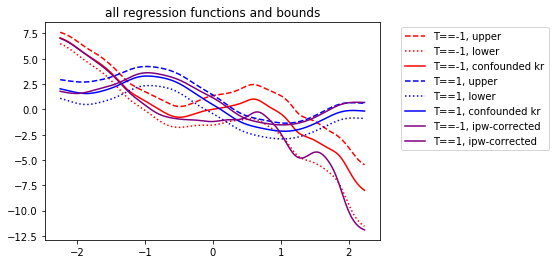

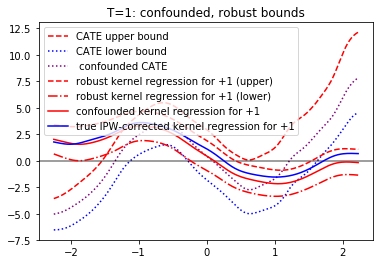

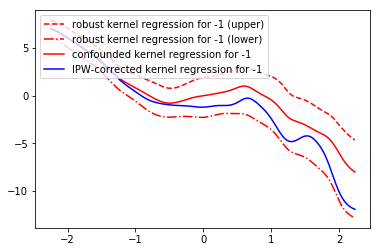

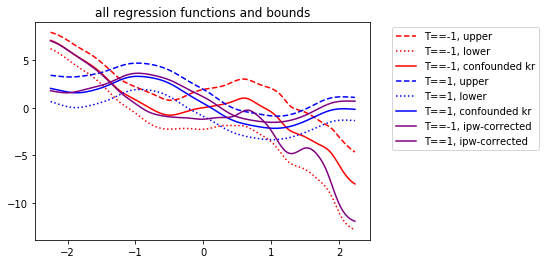

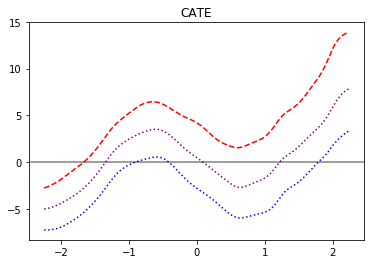

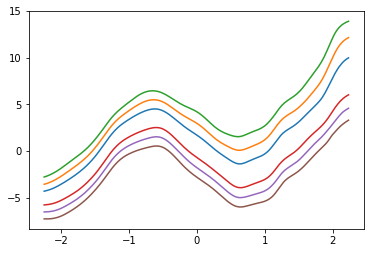

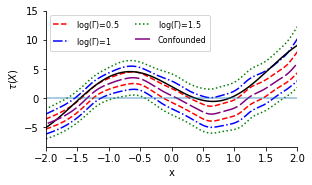

In [190]:
clf = LogisticRegression(); clf.fit(x[:,CATE_ind].reshape(-1,1), T)
propensities = clf.predict_proba(x[:,CATE_ind].reshape(-1,1))
nominal_propensities_pos = propensities[:,1]
q0x0 = np.asarray( [nominal_propensities_pos[i] if T[i] == 1 else 1-nominal_propensities_pos[i]  for i in range(n)] )
data['q0'] = q0x0

diff_gams_resx0 = plot_cate_diff_gams(xs, data, GAMS, s0, s1)
colors = ['r', 'b', 'g','gray', 'brown']
fig,ax = plt.subplots(figsize=(4.5,2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plot_mult_gams(xs, diff_gams_resx0, (GAMS), colors)
# plot_mult_gams(xs, diff_gams_res_single, np.exp(GAMS), colors, ls='-.')
plt.xlabel('x')
plt.ylabel(r'$\tau(X)$')
plt.xlim(-2,2)
truecate = -(-2*xs + -2 + 2*np.sin(2*xs) - 2*np.sin(-2*xs))
plt.plot(xs, truecate,color='black')
[confT1,confT0] = get_confKR(xs, data, s0, s1)
plt.plot(xs, confT1 - confT0,label='Confounded',color='purple',dashes=(10,2))
plt.axhline(y=0,alpha=0.5)


plt.legend(ncol=2,fontsize=8)
plt.savefig('figs/partial_cate-1D-ablation-specified--x0.pdf',bbox_to_inches='tight')
